In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn import metrics
from math import sqrt
from prepare import percentage_stacked_plot
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")
import acquire
import prepare

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Top Military Strengths by Country using PCA

### Project Description and Goals
This is an analysis of the top 25 militaries by country with the highest defense budget. This can deliver insight into current and future capabilities at a glance. My overall goal here is to show the features that are related to defense budget and how this makes a force not to be reckoned with. In the future with more available data, we can deliver critical insight into the current and future size, shape, and capabilities of the world's key military powers.

### Data Aquisition

In [2]:
# acquires the data frame from acquire function
df = acquire.acquire_military()
df.head()

,country_code,Active Personnel,Aircraft Carriers,Armored Vehicles,Attack Helicopters,Available Manpower,Coastline Coverage,Corvettes,Dedicated Attack,Defense Budget,...,Square Land Area,Submarines,Tanker Fleet,Tanks,Total Aircraft Strength,Total Population,Towed Artillery,Trainers,Transports,Waterways (usable)
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,0,0,530,0,14611901,0,0,0,99050000,...,652230,0,0,0,0,37466414,60,0,0,1200
Albania,ALB,8000,0,76,0,1513309,362,0,0,192400000,...,28748,0,0,0,19,3088385,0,0,0,41
Algeria,ALG,130000,0,6461,45,20916812,998,6,22,9700000000,...,2381741,6,5,2196,552,43576691,450,87,58,0
Angola,ANG,107000,0,1210,15,6728529,1600,0,18,1059270000,...,1246700,0,0,320,299,33642646,585,61,30,1300
Argentina,ARG,83000,0,800,0,20180574,4989,9,6,3064800000,...,2780400,2,2,349,218,45864941,172,70,22,11000


### Data Preparation

In [3]:
#df.reset_index

In [4]:
# prepares data frame from prepare function
df = prepare.prep_military(df)
df.head()

,country_code,active_personnel,air_carriers,armored_vehicles,arty,attack_aircraft,avail_manpower,corvettes,defense_budget,destroyers,...,subs,tanker_fleet,tanks,total_pop,trainers,transports,total_air_strength,total_sea_strength,total_land_strength,total_strengths
country,,,,,,,,,,,,,,,,,,,,,
United States,USA,1390000,20,45193,2837,1693,147399295,22,770000000000,92,...,68,627,6612,334998398,2661,982,25447,220,56008,81675
China,CHN,2000000,3,35000,5854,652,754864769,70,250240000000,41,...,79,3,5250,1397897720,399,286,5651,430,49264,55345
Russia,RUS,850000,1,30122,14145,1283,69737187,86,154000000000,15,...,70,20,12420,142320790,522,445,8118,291,60078,68487
United Kingdom,UKD,194000,2,5015,215,47,30857260,0,68000000000,6,...,10,9,227,67081000,247,40,1291,67,5501,6859
Germany,GER,184000,0,9217,121,130,36755601,5,50300000000,0,...,6,0,266,79903481,37,43,1155,35,9642,10832


#### Data Preparation Summary:
Before data preparation there were over 40 different measurements of military power from 140 different countries.
- Steps taken to clean and prep data:
    1. renamed columns (avoided spacing for easier coding)
    2. inspected data frame and found zeros or outliers where they likely should not be such as:
        1. changed to mean of entire feature.
        2. replaced outliers with zero.
    3. created additional features by grouping some that could be fit into one feature such as:
        1. attack_aircraft = any attack type aircraft.
        2. air_carriers = any air type carriers.
        3. arty = any type artillery.
        4. grouped air, land, and sea strengths into each individual category.
    4. Dropped columns that were not neccessary for this quick analysis (please see prepare.py file for feature drops)
    5. resorted the column titles.
    6. Only took the top 25 countries by highest defense budget.

### Initial thoughts before exploration:
- The strongest military power has the highest defense budget.
- Smaller countries in square land area have less of a defense budget.
- The more a country has in debt, the more the country has in defense budget
- The greater the population of a country, the higher the defense budget.

Text(0.5, 0.98, 'Top 25 Countries by Defense Budget')

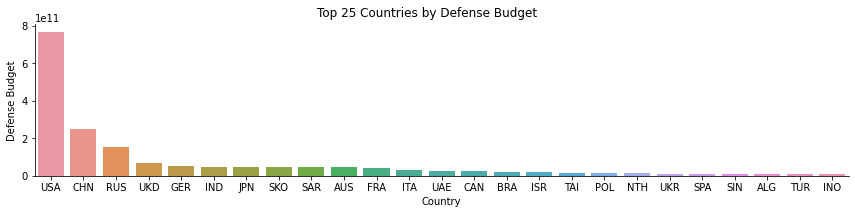

In [5]:
# Plots the countries by defense budget.
p = sns.catplot(kind='bar', data=df, x='country_code', y='defense_budget', height=3, aspect=4)
(p.set_axis_labels("Country", "Defense Budget"))  
p.fig.suptitle('Top 25 Countries by Defense Budget')

## Clearly USA has the highest defense budget. We will perform some hypothesis testing on what drives this.

### Now let's explore on our Train data frame.

In [6]:
# splits the data
df = prepare.split_military(df)

Train: 14 rows, 38 cols
Validate: 6 rows, 38 cols
Test: 5 rows, 38 cols


In [7]:
train, validate, test = df
train.shape

(14, 38)

In [8]:
train.head(25).T

country,Canada,China,Saudi Arabia,Poland,Japan,Brazil,United States,Spain,Germany,South Korea,United Arab Emirates,Russia,Italy,France
country_code,CAN,CHN,SAR,POL,JPN,BRA,USA,SPA,GER,SKO,UAE,RUS,ITA,FRA
active_personnel,70000,2000000,225000,120000,240000,360000,1390000,120000,184000,555000,65000,850000,170000,205000
air_carriers,0,3,0,0,4,1,20,1,0,2,0,1,2,4
armored_vehicles,1534,35000,6202,4786,5500,1958,45193,5033,9217,13990,9255,30122,6908,6558
arty,163,5854,2523,609,694,682,2837,236,121,6894,259,14145,162,214
attack_aircraft,0,652,115,30,142,89,1693,35,130,202,50,1283,154,69
avail_manpower,16315589,754864769,18087554,18711097,53615536,108857163,147399295,21739869,36755601,25857581,5716835,69737187,28075664,29957055
corvettes,0,70,4,2,6,2,22,0,5,11,9,86,0,0
defense_budget,23550574382,250240000000,46000000000,14500000000,47482740000,18785000000,770000000000,11750000000,50300000000,46320000000,25266000000,154000000000,29198401050,40900000000
destroyers,0,41,0,0,36,0,92,0,0,12,0,15,4,10


### First, I need to calculate the correlation coefficient for each pair of variables. I will also create visualizations on selected features in relation to defense budget.

<AxesSubplot:>

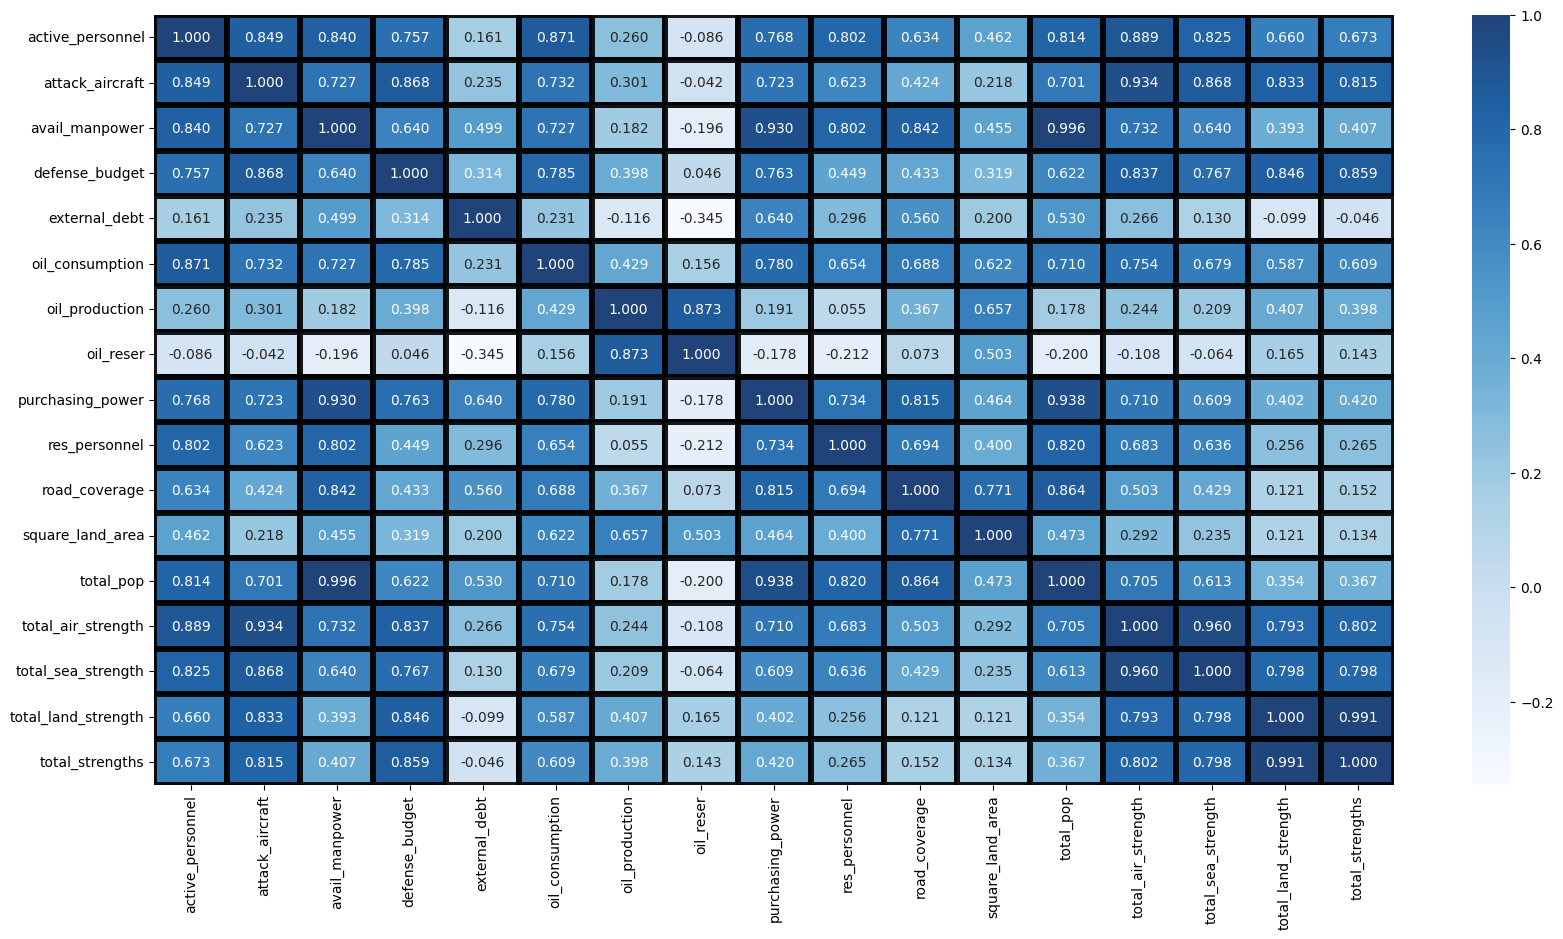

In [9]:
# using corr() function to find correlation between features
train_corr = train.drop(columns=['country_code','air_carriers','armored_vehicles','arty','corvettes',
                                'destroyers','fighters_interceptors','frigates','helos','merch_marine_fleet',
                                'mine_warfare','navy_ships','paramilitary','patrol_vess','rocket_proj',
                                'special_mission','subs','tanker_fleet','tanks','trainers','transports'
                                ]).corr(method='spearman')
# plots a heatmap and correlation values
kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(20, 10))
sns.heatmap(train_corr, cmap="Blues", annot=True, fmt='1.3f', **kwargs)

## HeatMap Takeaways: 
### Highest correlations to defense budget in number order of the selected features were:
1. Attack Aircrafts
2. Total Strengths
    1. Land
    2. Air
    3. Sea
3. Oil Consumption
4. Purchasing Power
5. Active Personnel
6. Avialable Manpower
7. Total Population
8. Reserve Personnel
9. Road Coverage
10. Oil Production
11. Square Land Area
12. External Debt
13. Oil Reserves

### Now lets take a closer look and perform correlation tests on how each one of these features is related to defense budget by country.

In [10]:
# Pre-Set valuse before performing test
n = train.shape[0]  # number of observations
degf = n - 2        # degrees of freedom: the # of values in the final calculation of a statistic that are free to vary.
conf_interval = .95 # desired confidence interval
α = 1 - conf_interval # sets alpha
print('Alpha\n')
print(α)

Alpha

0.050000000000000044


### Here I have combined air, land, and sea strength into a total strength feature. Lets explore this feature.

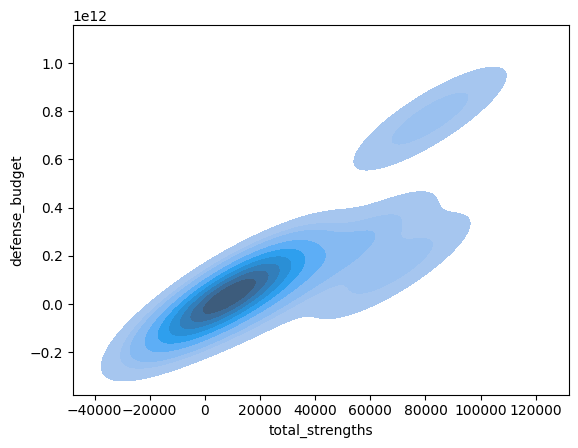

In [11]:
# plots a bivariate kdeplot
res = sns.kdeplot(train['total_strengths'],train['defense_budget'], shade=True)

### Which countries are these?

Text(0.5, 1.0, 'Total Strengths by Defense Budget')

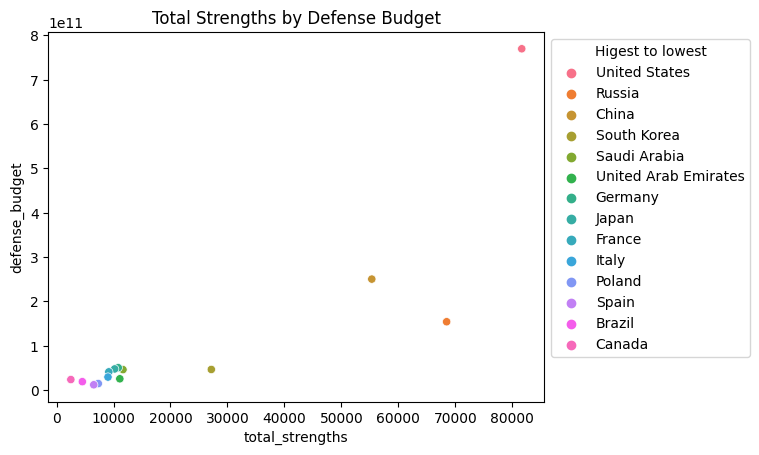

In [12]:
# plots air strength by defense budget with hue of country.
sns.scatterplot(x='total_strengths', y='defense_budget', hue='country',
                data=train.sort_values('total_strengths',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Total Strengths by Defense Budget")

### Hypothesis correlation testing on Defense Budget and Total Strengths
    - Is there a relationship between defense budget and air, land, and sea strengths?

- $H_0$: There is no relationship between defense budget and total strengths (air, land, sea).
- $H_a$: There is a relationship between defense budget and total strengths (air, land, sea).

In [13]:
# Since my variables are not normally distributed I will use a scipy stats function spearmanr 
# to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train_corr.total_strengths, train_corr.defense_budget)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')
print("We reject the null hypothesis.")

Correlation Coefficient: 0.9460784313725492
P-value: 9.653942434819005e-09
We reject the null hypothesis.


### Here I will explore square land area feature.

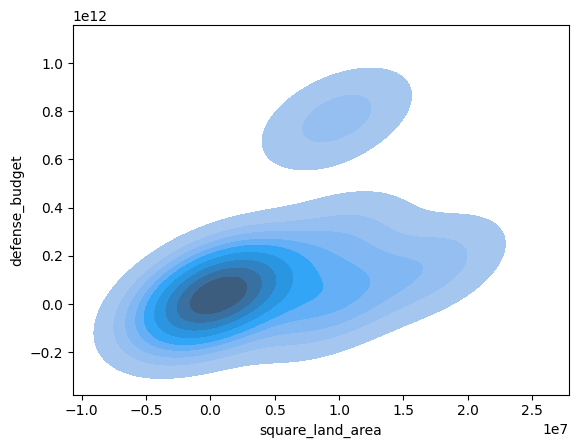

In [14]:
# plots a bivariate kdeplot
res = sns.kdeplot(train['square_land_area'],train['defense_budget'], shade=True)

Text(0.5, 1.0, 'Total Square Land Area by Defense Budget')

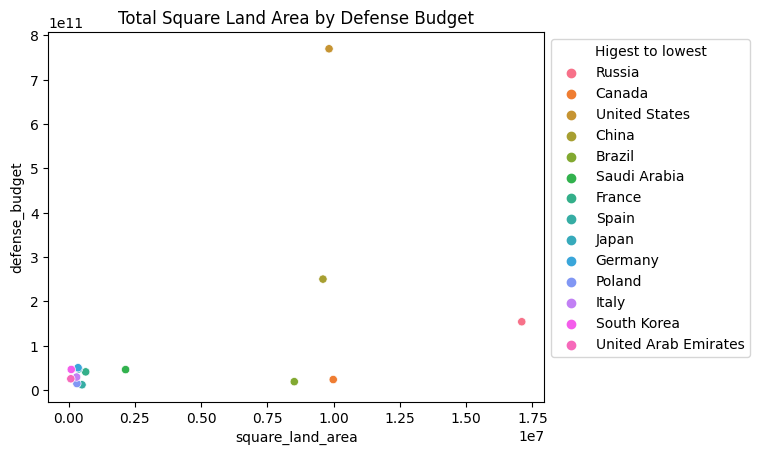

In [15]:
# plots total land strength by defense budget with hue of country.
#plt.figure(figsize = (8,5))
sns.scatterplot(x='square_land_area', y='defense_budget', hue='country',
                data=train.sort_values('square_land_area',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Total Square Land Area by Defense Budget")

### Hypothesis correlation testing on square land area and Defense Budget
    - Is there a relationship between the square land area and defense budget?
- $H_0$ : There is no relationship between defense budget and square land area.
- $H_a$ : There is a relationship between defense budget and square land area.

In [16]:
# Since my variables are not normally distributed I will use a scipy stats function spearmanr 
# to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train_corr.square_land_area, train_corr.defense_budget)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')
print("We fail to reject the null hypothesis.")

Correlation Coefficient: -0.5759803921568628
P-value: 0.01553176561917017
We fail to reject the null hypothesis.


### External Debt and Defense Budget

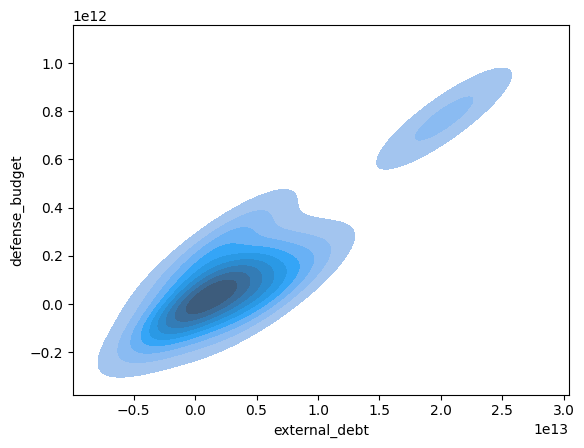

In [17]:
# plots a bivariate kdeplot
res = sns.kdeplot(train['external_debt'],train['defense_budget'],shade=True)

Text(0.5, 1.0, 'External Debt by Defense Budget')

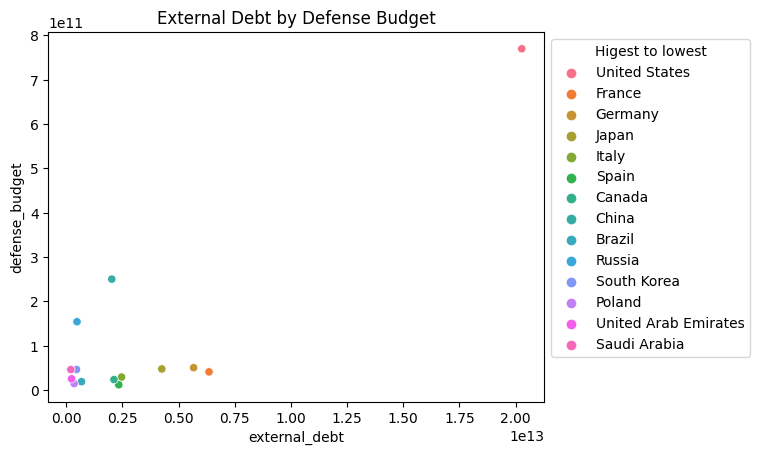

In [18]:
# plots total population by defense budget with hue of country.
sns.scatterplot(x='external_debt', y='defense_budget', hue='country',
                data=train.sort_values('external_debt',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("External Debt by Defense Budget")

### Hypothesis correlation testing on external debt and Defense Budget
    - Is there a relationship between the external debt and defense budget?
- $H_0$ : There is no relationship between defense budget and external debt.
- $H_a$ : There is a relationship between defense budget and external debt.

In [19]:
# Since my variables are not normally distributed I will use a scipy stats function spearmanr 
# to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train_corr.external_debt, train_corr.defense_budget)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')
print("We fail to reject the null hypothesis.")

Correlation Coefficient: -0.06127450980392158
P-value: 0.8152828502754565
We fail to reject the null hypothesis.


### Total Population and Defense Budget

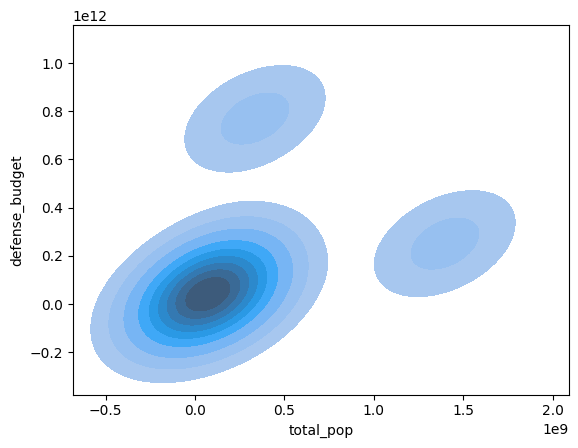

In [20]:
# plots a bivariate kdeplot
res = sns.kdeplot(train['total_pop'],train['defense_budget'],shade=True)

Text(0.5, 1.0, 'Total Population by Defense Budget')

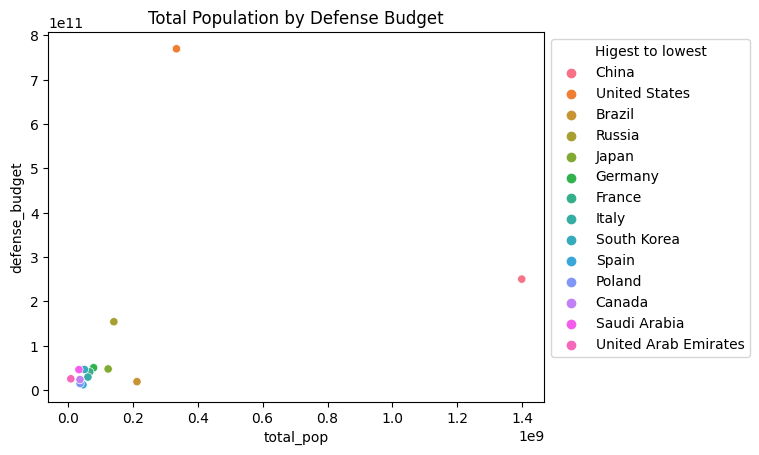

In [21]:
# plots total sea strength by defense budget with hue of country.
sns.scatterplot(x='total_pop', y='defense_budget', hue='country',
                data=train.sort_values('total_pop',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Total Population by Defense Budget")

### Hypothesis correlation testing on total population and Defense Budget
    - Is there a relationship between the total population and defense budget?
- $H_0$ : There is no relationship between defense budget and total population.
- $H_a$ : There is a relationship between defense budget and total population.

In [22]:
# Since my variables are not normally distributed I will use a scipy stats function spearmanr 
# to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train_corr.total_pop, train_corr.defense_budget)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')
print("We fail to reject the null hypothesis.")

Correlation Coefficient: 0.08088235294117649
P-value: 0.7576329086921563
We fail to reject the null hypothesis.


### Oil Consumption and Defense Budget

Text(0.5, 1.0, 'Oil Consumption by Defense Budget')

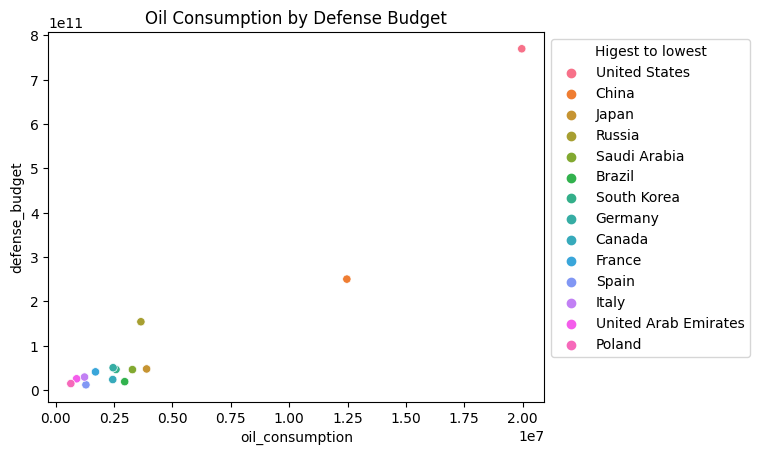

In [23]:
# plots total population by defense budget with hue of country.
sns.scatterplot(x='oil_consumption', y='defense_budget', hue='country',
                data=train.sort_values('oil_consumption',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Oil Consumption by Defense Budget")

### Road Coverage and Defense Budget

Text(0.5, 1.0, 'Road Coverage by Defense Budget')

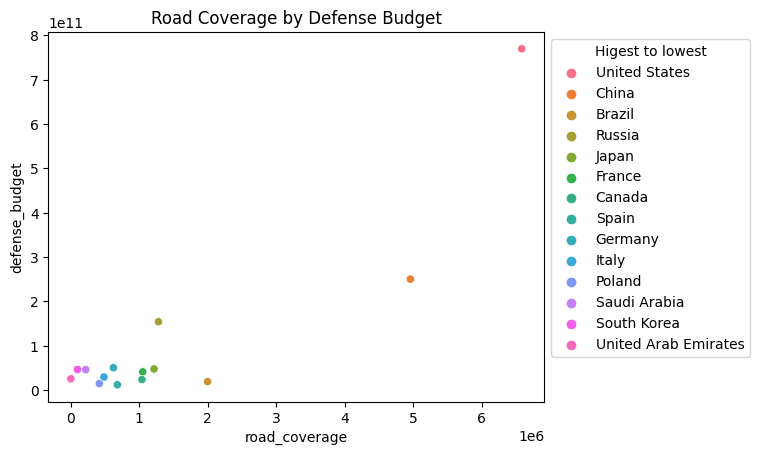

In [24]:
# plots total population by defense budget with hue of country.
sns.scatterplot(x='road_coverage', y='defense_budget', hue='country',
                data=train.sort_values('road_coverage',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Road Coverage by Defense Budget")

### Oil Production and Defense Budget

Text(0.5, 1.0, 'Oil Production by Defense Budget')

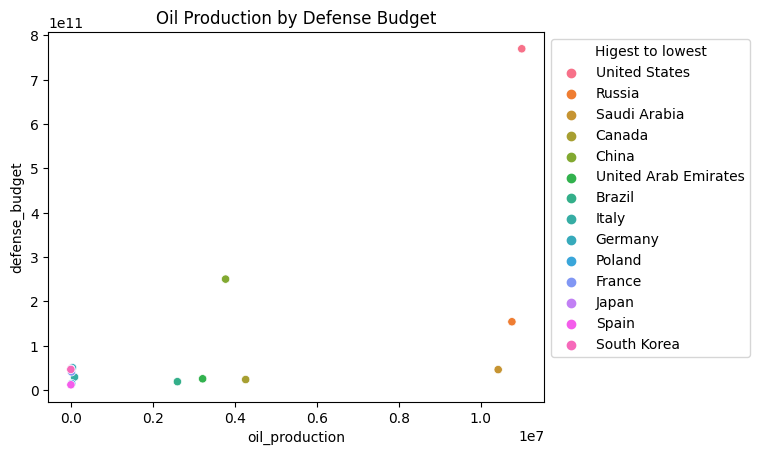

In [25]:
# plots total sea strength by defense budget with hue of country.
sns.scatterplot(x='oil_production', y='defense_budget', hue='country',
                data=train.sort_values('oil_production',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Oil Production by Defense Budget")

### Available Manpower and Defense Budget

Text(0.5, 1.0, 'Available Manpower by Defense Budget')

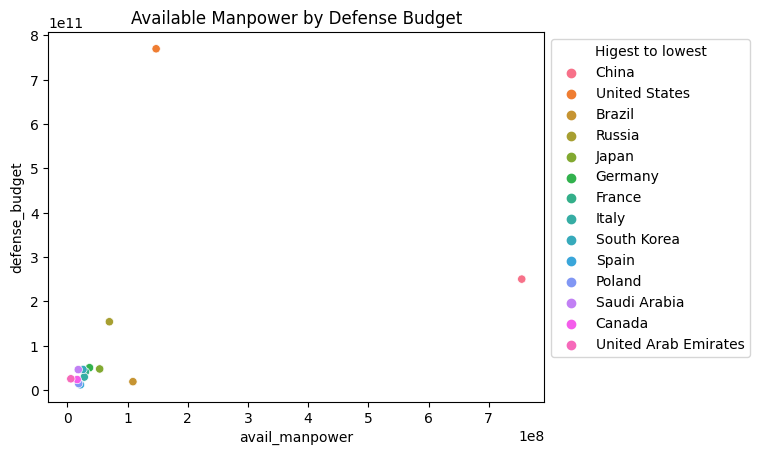

In [26]:
# plots total sea strength by defense budget with hue of country.
sns.scatterplot(x='avail_manpower', y='defense_budget', hue='country',
                data=train.sort_values('avail_manpower',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Available Manpower by Defense Budget")

# Based off these visualizations, USA, Russia, and China are always in the top three.  

## Now lets create a new dataframe that ranks each individual feature from 1 being the highest to 14 being the lowest.

In [27]:
# ranks the countries by feature
rank1=train.rank(ascending=False,method='min')
#rank1['country']=train['country']
rank1['country_code']=train['country_code']

# Ranks each feature of train (14)  in order by defense budgets
rank2=rank1.sort_values('defense_budget', ascending=True).head(14)
rank2=rank2.set_index('country_code')
rank2=rank2.T
#rank2=rank2.drop('country', axis=0)
rank2

country_code,USA,CHN,RUS,GER,JPN,SKO,SAR,FRA,ITA,UAE,CAN,BRA,POL,SPA
active_personnel,2.0,1.0,3.0,9.0,6.0,4.0,7.0,8.0,10.0,14.0,13.0,5.0,11.0,11.0
air_carriers,1.0,4.0,7.0,10.0,2.0,5.0,10.0,2.0,5.0,10.0,10.0,7.0,10.0,7.0
armored_vehicles,1.0,2.0,3.0,6.0,10.0,4.0,9.0,8.0,7.0,5.0,14.0,13.0,12.0,11.0
arty,4.0,3.0,1.0,14.0,6.0,2.0,5.0,11.0,13.0,9.0,12.0,7.0,8.0,10.0
attack_aircraft,1.0,3.0,2.0,7.0,6.0,4.0,8.0,10.0,5.0,11.0,14.0,9.0,13.0,12.0
avail_manpower,2.0,1.0,4.0,6.0,5.0,9.0,12.0,7.0,8.0,14.0,13.0,3.0,11.0,10.0
corvettes,3.0,2.0,1.0,7.0,6.0,4.0,8.0,11.0,11.0,5.0,11.0,9.0,9.0,11.0
defense_budget,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
destroyers,1.0,2.0,4.0,8.0,3.0,5.0,8.0,6.0,7.0,8.0,8.0,8.0,8.0,8.0
external_debt,1.0,8.0,10.0,3.0,4.0,11.0,14.0,2.0,5.0,13.0,7.0,9.0,12.0,6.0


### Which features is USA rank as number 1?

In [28]:
# takes the number one positions from ranked data frame for USA.
df_usa=pd.DataFrame(rank2[rank2['USA']==1.0].index)

# lists the features where USA is ranked number 1.
np.array(df_usa[0])

array(['air_carriers', 'armored_vehicles', 'attack_aircraft',
       'defense_budget', 'destroyers', 'external_debt',
       'fighters_interceptors', 'helos', 'oil_consumption',
       'oil_production', 'road_coverage', 'special_mission',
       'tanker_fleet', 'trainers', 'transports', 'total_air_strength',
       'total_strengths'], dtype=object)

## USA has 15 features where they are ranked No. 1!!! that is 43% of the selected features.

### How many features does C-H-I-N-A have as no. 1?

In [29]:
# Lists the features where China is ranked number 1.
df_china=pd.DataFrame(rank2[rank2['CHN']==1.0].index)
np.array(df_china[0])

array(['active_personnel', 'avail_manpower', 'frigates',
       'merch_marine_fleet', 'navy_ships', 'paramilitary', 'patrol_vess',
       'purchasing_power', 'subs', 'total_pop', 'total_sea_strength'],
      dtype=object)

###  What about Russia?

In [30]:
# Lists the features where Russia is ranked number 1.
df_russia=pd.DataFrame(rank2[rank2['RUS']==1.0].index)
np.array(df_russia[0])

array(['arty', 'corvettes', 'mine_warfare', 'rocket_proj',
       'square_land_area', 'tanks', 'total_land_strength'], dtype=object)

## Preprocessing for Modeling

### Here I will prepare the data from modeling to determine  which countries occupyt their own clusters.

In [31]:
# Scales data using MinMaxScaler
train_scaled, validate_scaled, test_scaled = prepare.scale_data(train, validate, test)
# removes country and country code
train_scaled

,active_personnel,air_carriers,armored_vehicles,arty,attack_aircraft,avail_manpower,corvettes,defense_budget,destroyers,external_debt,...,subs,tanker_fleet,tanks,total_pop,trainers,transports,total_air_strength,total_sea_strength,total_land_strength,total_strengths
country,,,,,,,,,,,,,,,,,,,,,
Canada,0.002584,0.00,0.000000,0.002995,0.000000,0.014148,0.000000,0.015563,0.000000,0.095651,...,0.050633,0.009569,0.000000,0.020235,0.036585,0.000000,0.000000,0.000000,0.000000,0.000000
China,1.000000,0.15,0.766532,0.408799,0.385115,1.000000,0.813953,0.314527,0.445652,0.090821,...,1.000000,0.004785,0.418869,1.000000,0.137957,0.264271,0.200162,1.000000,0.814508,0.667429
Saudi Arabia,0.082687,0.00,0.106920,0.171278,0.067927,0.016513,0.046512,0.045170,0.000000,0.000000,...,0.000000,0.035088,0.079429,0.017959,0.058308,0.013742,0.034263,0.062189,0.142078,0.115648
Poland,0.028424,0.00,0.074486,0.034797,0.017720,0.017345,0.023256,0.003627,0.000000,0.007308,...,0.012658,0.000000,0.063300,0.020410,0.022485,0.013742,0.005899,0.002488,0.080207,0.060919
Japan,0.090439,0.20,0.090840,0.040859,0.083875,0.063938,0.069767,0.047125,0.391304,0.201744,...,0.265823,0.011164,0.074728,0.082729,0.147866,0.024313,0.084970,0.176617,0.094650,0.097157
Brazil,0.152455,0.05,0.009712,0.040003,0.052569,0.137677,0.023256,0.009278,0.000000,0.023728,...,0.088608,0.003190,0.028935,0.146673,0.065930,0.094080,0.025374,0.037313,0.023637,0.025527
United States,0.684755,1.00,1.000000,0.193668,1.000000,0.189125,0.255814,1.000000,1.000000,1.000000,...,0.860759,1.000000,0.529259,0.234245,1.000000,1.000000,1.000000,0.477612,0.930187,1.000000
Spain,0.028424,0.05,0.080144,0.008200,0.020673,0.021388,0.000000,0.000000,0.000000,0.106311,...,0.025316,0.000000,0.019857,0.026947,0.049924,0.013742,0.007758,0.034826,0.065473,0.050814
Germany,0.061499,0.00,0.175977,0.000000,0.076787,0.041432,0.058140,0.050841,0.000000,0.272353,...,0.075949,0.000000,0.014913,0.050465,0.000000,0.007400,0.018505,0.017413,0.134874,0.105190


Text(0.5, 1.0, 'Scaled')

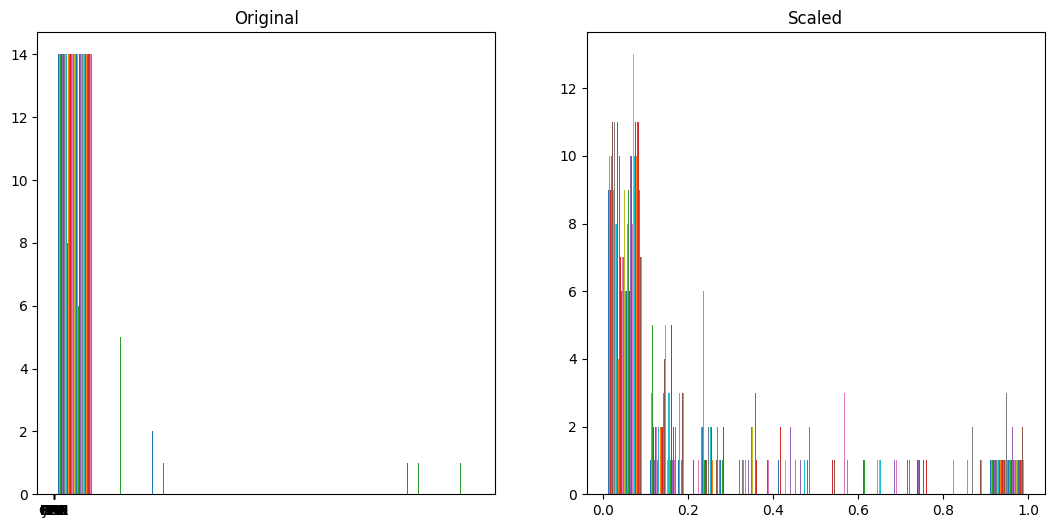

In [32]:
# plots original df and scaled into MinMaxScaler 0-1

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(train)
plt.title('Original')
plt.subplot(122)
plt.hist(train_scaled)
plt.title('Scaled')

### Here we will employ Principal Component Analysis (PCA) to reduce the number of features in our data set.

In [33]:
# Standardize data using PCA
pca = PCA()
pca.fit(train_scaled)

PCA()

### Next we decide how many features we would like to keep based on the cumulative variance plot

In [34]:
# shows how much variance is explained by each individual component.
pca.explained_variance_ratio_

array([6.02419116e-01, 1.85556091e-01, 9.21521591e-02, 4.74690189e-02,
       3.11820159e-02, 1.73366703e-02, 1.11509891e-02, 5.96948595e-03,
       2.97603672e-03, 1.66215679e-03, 1.29980663e-03, 6.48977317e-04,
       1.77476893e-04, 8.59316880e-33])

### The total is 14.

Text(0, 0.5, 'Cumulative Explained Variance')

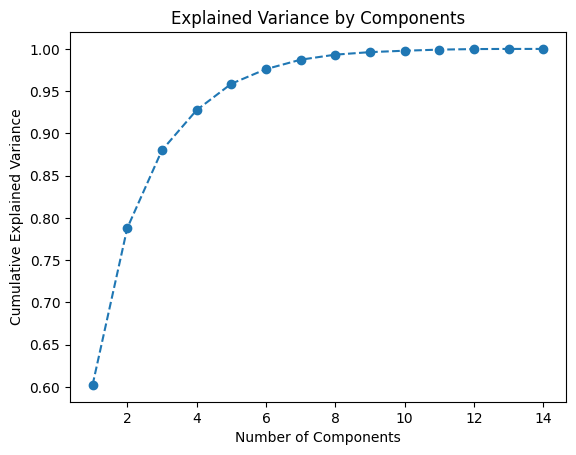

In [35]:
# plots the number of individual components which was 14.
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variance by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

### The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis) (14). We will preserve around 80% of the variance. We decide to keep 3 components since it is well above 80%.

## Here we will perform PCA with the selected number of components.

In [36]:
# we choose three components which is above 80%
pca = PCA(n_components = 3)
# fit the model to our data with the selected number of compenents = 3
pca.fit(train_scaled)

PCA(n_components=3)

In [37]:
# will only need the caluculated resulting components scores for the elements in our data set.
pca.transform(train_scaled)

array([[-0.85698871,  0.16316417,  0.32492051],
       [ 2.43794355, -1.61599204, -0.91377506],
       [-0.63751553,  0.10745919,  0.71386167],
       [-0.953682  ,  0.05415834, -0.01419765],
       [-0.35397929,  0.17150665, -0.40217767],
       [-0.54810312, -0.12321788, -0.22603834],
       [ 3.13956734,  2.00627193, -0.14170719],
       [-0.91476817,  0.07315129, -0.17629485],
       [-0.79115256,  0.15565446, -0.17910268],
       [-0.14089204, -0.38708755, -0.10882143],
       [-0.8822407 ,  0.12362449,  0.21561917],
       [ 1.91322076, -0.90864113,  1.39024076],
       [-0.75743811,  0.05087878, -0.22152472],
       [-0.65397143,  0.12906931, -0.26100252]])

# Modeling

In [38]:
# Fits the model with the data on our selected number of compenents to perform segmentation based on principal
# components scores instead of original features.
train_model = pca.transform(train_scaled)

## Next we will combine PCA and K-Means to segment our data where we use the scores obtained by the PCA for the fit.

## First need to determine the number of clusters in a K-Means algorithm.

In [39]:
# Within Cluster Sum of Squares = wcss. Fit K-Means using the transformed data from the PCA. Test an algorithm with up
# to 14 clusters
wcss = []
for i in range(1,15):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(train_model)
    wcss.append(kmeans_pca.inertia_)

## Now we plot the WCSS against the number of components on a graph.

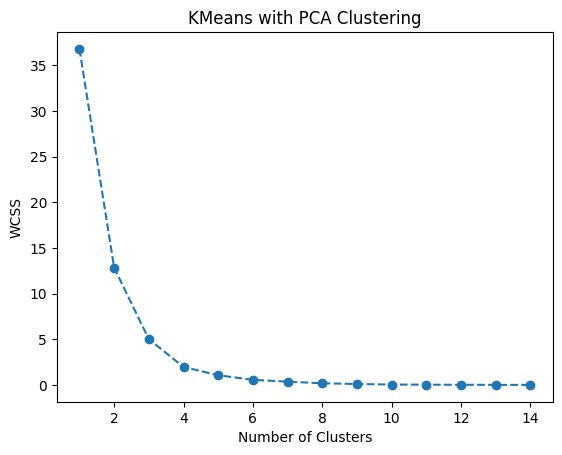

In [40]:
#plots whe WCSS gainanst the number of components 14.
plt.plot(range(1, 15), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title("KMeans with PCA Clustering")
plt.show()

## From the graph we determine the number of clusters to keep using elbow method which is 4 clusters

### Next we will implement it and fit the model with the PCA Scores.

In [41]:
# four clusters chosen, so we run Kmeans with the number of clusters equal to four
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
# fit data with the kmeans pca model
kmeans_pca.fit(train_model)
cluster = kmeans_pca.predict(train_model)

### Next we anaylze the results of PCA and K-Means clustering

In [42]:
# Create new data frame with original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([train_scaled.reset_index(drop = True), pd.DataFrame(train_model)], axis = 1)
df_segm_pca_kmeans.columns.values[-3:] = ['component_1','component_2','component_3']

# adds the last column which contains the pca k-means clustering labels
df_segm_pca_kmeans['Segment_KMeans_PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans.head()

,active_personnel,air_carriers,armored_vehicles,arty,attack_aircraft,avail_manpower,corvettes,defense_budget,destroyers,external_debt,...,trainers,transports,total_air_strength,total_sea_strength,total_land_strength,total_strengths,component_1,component_2,component_3,Segment_KMeans_PCA
0,0.002584,0.00,0.000000,0.002995,0.000000,0.014148,0.000000,0.015563,0.000000,0.095651,...,0.036585,0.000000,0.000000,0.000000,0.000000,0.000000,-0.856989,0.163164,0.324921,1
1,1.000000,0.15,0.766532,0.408799,0.385115,1.000000,0.813953,0.314527,0.445652,0.090821,...,0.137957,0.264271,0.200162,1.000000,0.814508,0.667429,2.437944,-1.615992,-0.913775,2
2,0.082687,0.00,0.106920,0.171278,0.067927,0.016513,0.046512,0.045170,0.000000,0.000000,...,0.058308,0.013742,0.034263,0.062189,0.142078,0.115648,-0.637516,0.107459,0.713862,1
3,0.028424,0.00,0.074486,0.034797,0.017720,0.017345,0.023256,0.003627,0.000000,0.007308,...,0.022485,0.013742,0.005899,0.002488,0.080207,0.060919,-0.953682,0.054158,-0.014198,1
4,0.090439,0.20,0.090840,0.040859,0.083875,0.063938,0.069767,0.047125,0.391304,0.201744,...,0.147866,0.024313,0.084970,0.176617,0.094650,0.097157,-0.353979,0.171507,-0.402178,1


### Next we create a new column named 'Clusters' and map the four clusters directly inside it.

In [43]:
# create new column named Clusters and map the four clusters directly inside it.
df_segm_pca_kmeans['clusters'] = df_segm_pca_kmeans['Segment_KMeans_PCA'].map({0:'1', 1:'2', 2:'3', 3:'4'})

### Now lets visualize the clusters with respect to the first two components and use them as axes. Result of PCA was to determin the most important compenents so we can be sure they explain more than the third one.

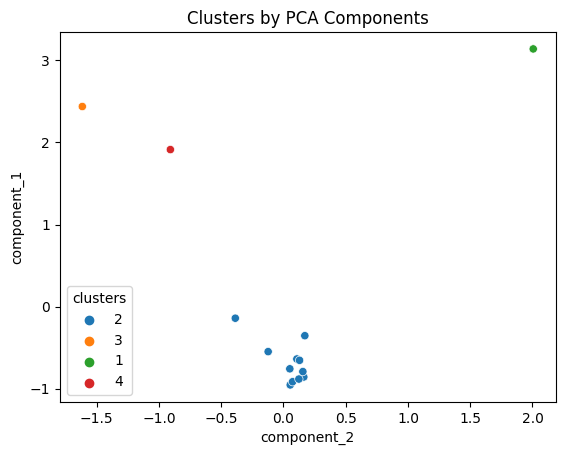

In [44]:
# Plots data by PCA Components.
x_axis = df_segm_pca_kmeans['component_2'] # second component
y_axis = df_segm_pca_kmeans['component_1'] # first compenent
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['clusters'])
plt.title('Clusters by PCA Components')
plt.show()

In [45]:
# creates a new data frame with components and cluster only
pca = PCA(n_components=3)
pca_fit = pca.fit_transform(train_model)

train_pca = pd.DataFrame(data=pca_fit, columns=['component_1', 'component_2','component_3'])
train_pca['cluster'] = kmeans_pca.predict(train_model)
train_pca.head(14)

,component_1,component_2,component_3,cluster
0,-0.856989,0.163164,0.324921,1
1,2.437944,-1.615992,-0.913775,2
2,-0.637516,0.107459,0.713862,1
3,-0.953682,0.054158,-0.014198,1
4,-0.353979,0.171507,-0.402178,1
5,-0.548103,-0.123218,-0.226038,1
6,3.139567,2.006272,-0.141707,0
7,-0.914768,0.073151,-0.176295,1
8,-0.791153,0.155654,-0.179103,1
9,-0.140892,-0.387088,-0.108821,1


# Conclusion

### Reducing the number of variables by combining them into larger and more meaningful features was our overall goal and from the graph we can observe the separate clusters. The difference between components is now as large as possible. When we began, the data set had many features so reducing the dimensionality, using PCA we found out we only need three components to separate the data.
### Now we can see that USA, China, and Russia occupy their own clusters which means they have very strong militaries and definitely outnumber any other countries defense budget.